In [18]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/Dữ-liệu-Lịch-sử-VNM.csv')
df1=df.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 5s 166ms/step - loss: 0.0169 - val_loss: 0.0066
Epoch 2/100
14/14 [==============================] - 1s 90ms/step - loss: 0.0046 - val_loss: 0.0253
Epoch 3/100
14/14 [==============================] - 1s 70ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 4/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0014 - val_loss: 0.0071
Epoch 5/100
14/14 [==============================] - 1s 63ms/step - loss: 7.0459e-04 - val_loss: 0.0023
Epoch 6/100
14/14 [==============================] - 1s 66ms/step - loss: 3.7547e-04 - val_loss: 0.0017
Epoch 7/100
14/14 [==============================] - 1s 64ms/step - loss: 3.2153e-04 - val_loss: 0.0016
Epoch 8/100
14/14 [==============================] - 1s 65ms/step - loss: 3.1357e-04 - val_loss: 0.0016
Epoch 9/100
14/14 [==============================] - 1s 66ms/step - loss: 3.0705e-04 - val_loss: 0.0015
Epoch 10/100
14/14 [==============================] - 2s 117ms/step - loss: 2.9

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 15ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [20]:
# 7. Đánh giá độ chính xác validate, test

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print("Validation MAPE:", mape)

# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
print("Validation RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(yval, y_pred_val)
print("Validation MAE:", mae)

print("==============================================================================")



# Độ lỗi bình phương trung bình (Mean Squared Error)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("Testing RMSE:", rmse)

# Độ sai lệch tuyệt đối trung bình (Mean Absolute Error)
mae = mean_absolute_error(ytest, y_pred)
print("Testing MAE:", mae)

# Độ sai lệch tuyệt đối phần trăm trung bình (Mean Absolute Percentage Error)
mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", mape)




Validation MAPE: 1.6917993682534482
Validation RMSE: 3527.4440586166525
Validation MAE: 2820.5222039473683
Testing RMSE: 3206.135536936555
Testing MAE: 1664.7441744942196
Testing MAPE: 1.4933624594800077


In [23]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=79
i=0
while(i<30):
    
    if(len(temp_input)>79):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.85189253]
80
1 day input [0.91563001 0.94422571 0.97283015 0.98713237 0.95495893 0.94422571
 0.95852793 0.95852793 0.95852793 0.97998564 0.99427911 0.96710926
 0.98713237 0.96568341 0.93707897 0.95138119 0.95852793 0.93779627
 0.90847453 0.91133497 0.88916871 0.86557661 0.86557661 0.89418105
 0.89418105 0.90847453 0.90132779 0.91705586 0.84770539 0.83697216
 0.82982543 0.87344064 0.8963242  0.87916153 0.91634731 0.94422571
 0.91563001 0.91920775 0.92635449 0.94065671 0.97855104 0.94422571
 0.97711644 0.93421853 0.93421853 0.90204509 0.95352434 0.95495893
 0.96496612 0.96568341 0.97283015 0.94422571 0.96568341 0.99071012
 1.         0.99356181 0.97640789 0.95566749 0.93135808 0.91920775
 0.90430195 0.88371025 0.90430195 0.9113962  0.8979075  0.9050105
 0.91920775 0.86241875 0.89081325 0.84680439 0.84467874 0.81983574
 0.79924404 0.78433824 0.84822149 0.876616   0.9050105  0.85532449
 0.85189253]
1 day output [[0.8399111]]
2 day input [0.94422571 0.97283015 0.98713237 0.95495893 0.944

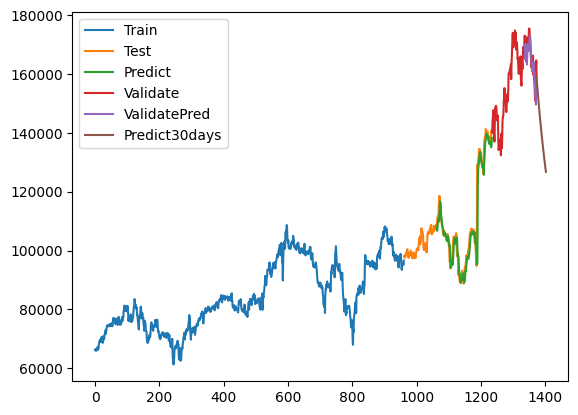

In [24]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()